In [1]:
!pip install py7zr


In [13]:
# ──────────── 1. Imports & Paths ────────────
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Only show errors


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from zipfile import ZipFile
import py7zr

from sklearn.model_selection import train_test_split

import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models, optimizers, Input
from tensorflow.keras.applications.resnet50 import ResNet50

Num GPUs Available: 2


In [14]:
TRAIN7Z_PATH   = "/kaggle/input/cifar-10/train.7z"
TRAIN_CSV_PATH = "/kaggle/input/cifar-10/trainLabels.csv"


In [23]:


# Extract .7z only ONCE
with py7zr.SevenZipFile("/kaggle/input/cifar-10/train.7z", mode='r') as archive:
    archive.extractall(path="/kaggle/working/train_extracted")


In [24]:
# ──────────── 3. Load Filenames & Labels ────────────
TRAIN_DIR = "/kaggle/working/train_extracted/train"

labels_df = pd.read_csv(TRAIN_CSV_PATH)

In [25]:
label_map = {
    'airplane':0, 'automobile':1, 'bird':2, 'cat':3, 'deer':4,
    'dog':5,      'frog':6,       'horse':7,'ship':8,'truck':9
}
labels = labels_df['label'].map(label_map).values
ids     = labels_df['id'].values

In [26]:
from PIL import Image
import numpy as np
import os

ids = list(labels_df['id'])  # or ids = labels_df['id'].tolist()
data = []

for img_id in ids:
    img_path = os.path.join(TRAIN_DIR, f"{img_id}.png")
    img = Image.open(img_path).convert('RGB')
    data.append(np.array(img))

X = np.array(data, dtype=np.float32)
y = labels


In [28]:
# Normalize pixels to [0,1]
X /= 255.0
print(X)

[[[[0.00090734 0.00095348 0.00096886]
   [0.00066128 0.00070742 0.00069204]
   [0.00076894 0.00073818 0.00066128]
   ...
   [0.00242983 0.00202999 0.0016609 ]
   [0.00233756 0.00192234 0.00156863]
   [0.00227605 0.00190696 0.00158401]]

  [[0.00024606 0.00030757 0.00030757]
   [0.         0.         0.        ]
   [0.00027682 0.00012303 0.        ]
   ...
   [0.00189158 0.00135333 0.00084583]
   [0.00183007 0.00127643 0.00076894]
   [0.0018762  0.00133795 0.00087659]]

  [[0.00038447 0.00036909 0.00032295]
   [0.00024606 0.00010765 0.        ]
   [0.00075356 0.00041522 0.00012303]
   ...
   [0.00181469 0.00129181 0.00076894]
   [0.00184544 0.00129181 0.00076894]
   [0.00167628 0.00112265 0.00064591]]

  ...

  [[0.00319877 0.00261438 0.00147636]
   [0.00309112 0.00235294 0.00052288]
   [0.00304498 0.00247597 0.00039985]
   ...
   [0.00246059 0.00204537 0.00107651]
   [0.00086121 0.00047674 0.00010765]
   [0.00081507 0.00052288 0.00030757]]

  [[0.00276817 0.00213764 0.00147636]
   [0.0

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [35]:
# ──────────── 5. (Optional) Simple Dense Baseline ────────────
simple_model = keras.Sequential([
    keras.Input(shape=(32, 32, 3)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])



simple_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

simple_model.fit(X, y, validation_split=0.1, epochs=10)


Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.2057 - loss: 2.1852 - val_accuracy: 0.3004 - val_loss: 1.9734
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3034 - loss: 1.9445 - val_accuracy: 0.3338 - val_loss: 1.9078
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3311 - loss: 1.8845 - val_accuracy: 0.3394 - val_loss: 1.8738
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3438 - loss: 1.8538 - val_accuracy: 0.3508 - val_loss: 1.8403
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3543 - loss: 1.8229 - val_accuracy: 0.3566 - val_loss: 1.8245
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.3625 - loss: 1.7961 - val_accuracy: 0.3644 - val_loss: 1.7996
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3742 - loss: 1.7734 - val_accuracy: 0.3690 - val_loss: 1.7835
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3770 - loss: 1.7579 - 

In [40]:
# ──────────── 6. Build ResNet50-based Model ────────────
input_tensor = Input(shape=(32,32,3))
x = layers.UpSampling2D((2,2))(input_tensor)  # 32→64
x = layers.UpSampling2D((2,2))(x)             # 64→128
x = layers.UpSampling2D((2,2))(x)             # 128→256

resnet_base = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(256,256,3)
)
x = resnet_base(x)
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.BatchNormalization()(x)
output = layers.Dense(10, activation='softmax')(x)

model = models.Model(inputs=input_tensor, outputs=output)
model.compile(
    optimizer=optimizers.RMSprop(learning_rate=2e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [41]:
# ──────────── 7. Train ────────────
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=64
)

Epoch 1/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 494s 790ms/step - accuracy: 0.3274 - loss: 2.0349 - val_accuracy: 0.0955 - val_loss: 3.1640
Epoch 2/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 412s 732ms/step - accuracy: 0.6927 - loss: 1.0049 - val_accuracy: 0.1058 - val_loss: 2.8248
Epoch 3/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 411s 730ms/step - accuracy: 0.8195 - loss: 0.6988 - val_accuracy: 0.3250 - val_loss: 1.8643
Epoch 4/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 412s 731ms/step - accuracy: 0.8907 - loss: 0.5221 - val_accuracy: 0.9265 - val_loss: 0.3086
Epoch 5/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 411s 731ms/step - accuracy: 0.9283 - loss: 0.4044 - val_accuracy: 0.9293 - val_loss: 0.2701
Epoch 6/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 411s 730ms/step - accuracy: 0.9565 - loss: 0.3076 - val_accuracy: 0.9340 - val_loss: 0.2389
Epoch 7/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 411s 730ms/step - accuracy: 0.9684 - loss: 0.2509 - val_accuracy: 0.9315 - val_loss: 0.2491
Epoch 8/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 411s 730ms/step - accuracy: 0.9782 -

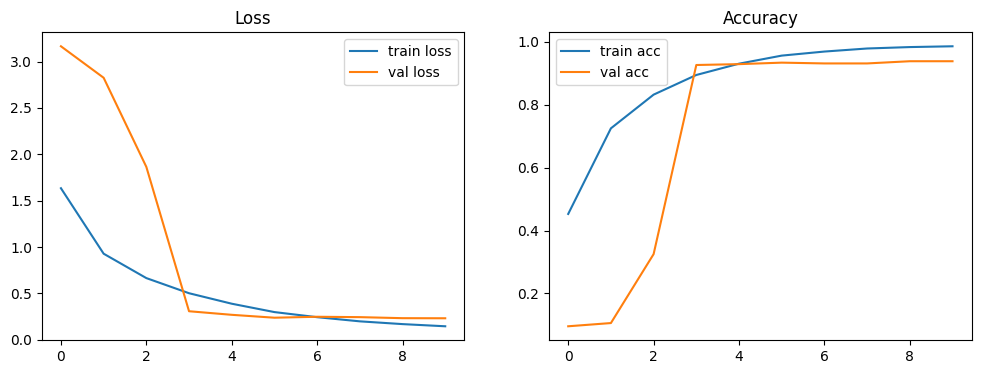

In [42]:
# ──────────── 8. Plot Training Curves ────────────
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')
plt.show()


In [ ]:
# ──────────── 10. Predict on Uploaded Image ────────────
from google.colab import files  # If using Kaggle, you can also drag‐and‐drop via the Data sidebar

labels_dictionary = {v:k for k,v in label_map.items()}
uploaded = files.upload()
for fn in uploaded:
    img = load_img(fn, target_size=(256,256))
    arr = img_to_array(img)/255.0
    inp = np.expand_dims(arr, 0)
    pred = model.predict(inp)
    cls = np.argmax(pred)
    conf = np.max(pred)
    print(f"File: {fn} → Predicted: {labels_dictionary[cls]}, Confidence: {conf*100:.2f}%")